#Building Point Cloud Segmentation for Architectural Elements *(Walls, Roofs, and Floors)*

This Colab notebook provides a comprehensive pipeline for segmenting 3D point cloud data of buildings to identify key architectural elements: walls, roofs, and floors. Utilizing deep learning, this model allows for accurate segmentation, making it easier to analyze and understand building structures from point cloud data.



# Imports

In [54]:
!pip install umap-learn

In [130]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import umap

import tensorflow as tf
import keras
from tensorflow.keras.layers import Layer
from keras import layers

from keras.regularizers import Regularizer
from keras.models import load_model

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sys import platlibdir
import seaborn as sns
import plotly.graph_objects as go

from collections import Counter
from imblearn.over_sampling import SMOTE

##Connecting to Gdrive

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading the dataset

We parse the dataset metadata in order to easily map model categories to their
respective directories and segmentation classes to colors for the purpose of
visualization.

In [57]:
with open("/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/BAPC/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Housing': {'directory': 'Buildings', 'lables': ['wall', 'roof', 'floor'], 'colors': ['blue', 'green', 'pink']}}


In this example, we train PointNet to segment the parts of a `House` model.

In [58]:
points_dir = "/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/BAPC/PartAnnotation/{}/points".format(
    metadata["Housing"]["directory"]
)
labels_dir = "/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/BAPC/PartAnnotation/{}/points_label".format(
    metadata["Housing"]["directory"]
)
LABELS = metadata["Housing"]["lables"]
COLORS = metadata["Housing"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

In [59]:
point_clouds= []
point_cloud_labels, all_labels = [], []
all_cat, label_data_cat = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))

#i=0

for point_file in tqdm(points_files):
    seg_file= point_file.replace("points/", "points_label/").replace(".pts", ".seg")
    point_cloud = np.loadtxt(point_file)
    point_cloud_labels = np.loadtxt(seg_file).astype("float32")

    point_clouds.append(point_cloud)
    all_labels.append(point_cloud_labels)

    label_data_cat = keras.utils.to_categorical(point_cloud_labels, num_classes=len(LABELS) + 1)

    all_cat.append(label_data_cat)

    #i=i+1

    #if i==50:
    #  break


100%|██████████| 2904/2904 [13:57<00:00,  3.47it/s]


In [60]:
print(f"point_clouds[0].shape:", point_clouds[0].shape)
print(f"all_labels[0].shape:", all_labels[0].shape)
print(f"all_cat[0].shape:", all_cat[0].shape)

print(f"nr of point_clouds", len(point_clouds),f"nr of labels",  len(all_labels), f"nr of onehot encoding labels", len(all_cat))

point_clouds[0].shape: (2598, 3)
all_labels[0].shape: (2598,)
all_cat[0].shape: (2598, 4)
nr of point_clouds 2904 nr of labels 2904 nr of onehot encoding labels 2904


In [61]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = all_cat[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    all_cat[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 2904/2904 [00:08<00:00, 338.02it/s]


In [62]:
print(f"point_clouds[0].shape:", point_clouds[0].shape)
print(f"all_labels[0].shape:", all_labels[0].shape)
print(f"all_cat[0].shape:", all_cat[0].shape)

print(f"nr of point_clouds", len(point_clouds),f"nr of labels",  len(all_labels), f"nr of onehot encoding labels", len(all_cat))

point_clouds[0].shape: (1024, 3)
all_labels[0].shape: (1024,)
all_cat[0].shape: (1024, 4)
nr of point_clouds 2904 nr of labels 2904 nr of onehot encoding labels 2904


#Clustering the point clouds

##Feature Extraction with UMAP
*Kmeans and DBSCAN clustering*

UMAP (Uniform Manifold Approximation and Projection) was chosen for dimensionality reduction because it effectively captures complex, non-linear relationships in our dataset while preserving both local and global structures. Unlike traditional linear methods like PCA, UMAP maintains the local neighborhood relationships crucial for point cloud data, ensuring that points close in high-dimensional space remain so in the reduced space. This capability leads to clearer visualizations with distinct cluster separations, making it easier to interpret how different classes of point clouds are distributed and related to one another. Ultimately, UMAP provides a more nuanced understanding of the data, which is essential for our analysis and insights.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


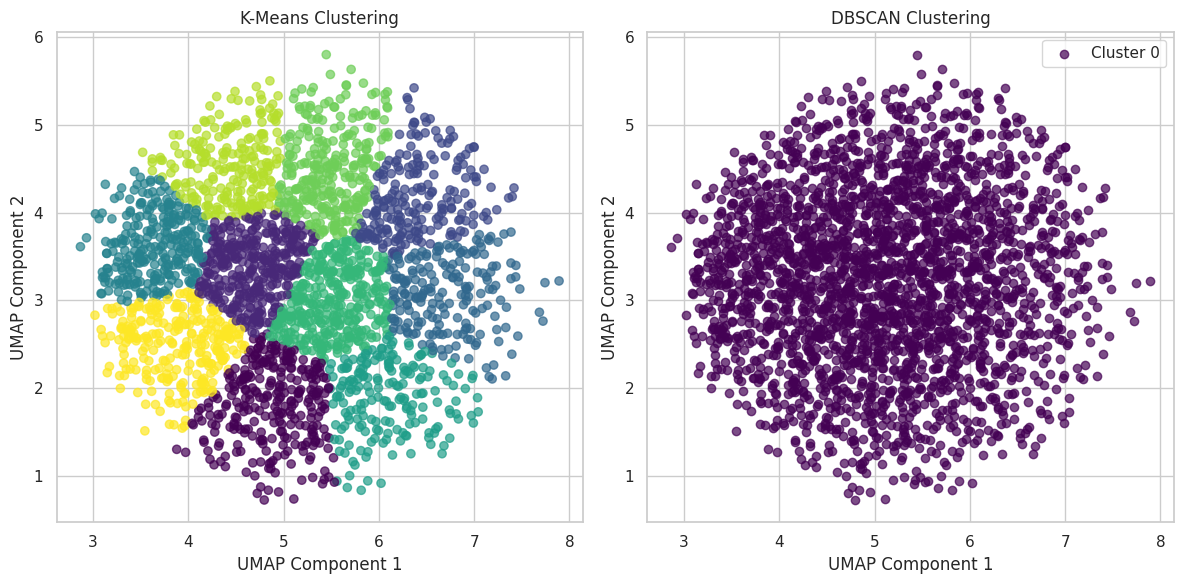

In [98]:
def flatten_point_clouds(point_clouds):
    return np.array([point_cloud.flatten() for point_cloud in point_clouds])

def extract_umap_features(point_clouds, n_components=2):
    flattened_point_clouds = flatten_point_clouds(point_clouds)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(flattened_point_clouds)

    reducer = umap.UMAP(n_components=n_components, random_state=42)
    umap_features = reducer.fit_transform(scaled_features)

    return umap_features

def apply_kmeans_clustering(umap_features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(umap_features)

    return labels

def apply_dbscan_clustering(umap_features, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(umap_features)

    return labels

def visualize_clustering_results(umap_features, kmeans_labels, dbscan_labels):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # K-Means Visualization
    axs[0].scatter(umap_features[:, 0], umap_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    axs[0].set_title("K-Means Clustering")
    axs[0].set_xlabel("UMAP Component 1")
    axs[0].set_ylabel("UMAP Component 2")

    # DBSCAN Visualization
    unique_labels = np.unique(dbscan_labels)
    for label in unique_labels:
        if label == -1:
            color = 'black'  # Noise points
        else:
            color = plt.cm.viridis(label / len(unique_labels))  # Normalize for colormap

        axs[1].scatter(umap_features[dbscan_labels == label, 0],
                       umap_features[dbscan_labels == label, 1],
                       color=color, label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.7)

    axs[1].set_title("DBSCAN Clustering")
    axs[1].set_xlabel("UMAP Component 1")
    axs[1].set_ylabel("UMAP Component 2")

    plt.legend()
    plt.tight_layout()
    plt.show()


# Extract UMAP features from the point clouds
umap_features = extract_umap_features(point_clouds, n_components=2)

# Apply K-Means on the extracted UMAP features
kmeans_labels = apply_kmeans_clustering(umap_features, n_clusters=10)

# Apply DBSCAN on the extracted UMAP features
dbscan_labels = apply_dbscan_clustering(umap_features, eps=0.5, min_samples=5)

# Visualize the clustering results
visualize_clustering_results(umap_features, kmeans_labels, dbscan_labels)


KMeans outperformed DBSCAN in our dataset primarily due to the nature of the data distribution and the characteristics of the clustering algorithms. KMeans is particularly effective when dealing with well-separated, spherical clusters, which is often the case in point cloud data where distinct groups are formed by different classes. It relies on centroids and minimizes the variance within each cluster, allowing it to efficiently group similar points together. On the other hand, DBSCAN, which identifies clusters based on density, struggles in datasets with varying densities or in the presence of noise and outliers. Our dataset likely contained clusters that were clearly defined, making KMeans a better fit as it effectively partitioned the data into meaningful groupings, leading to more coherent and interpretable clusters compared to the more flexible but less deterministic approach of DBSCAN.

##Vizualization of different clusters samples

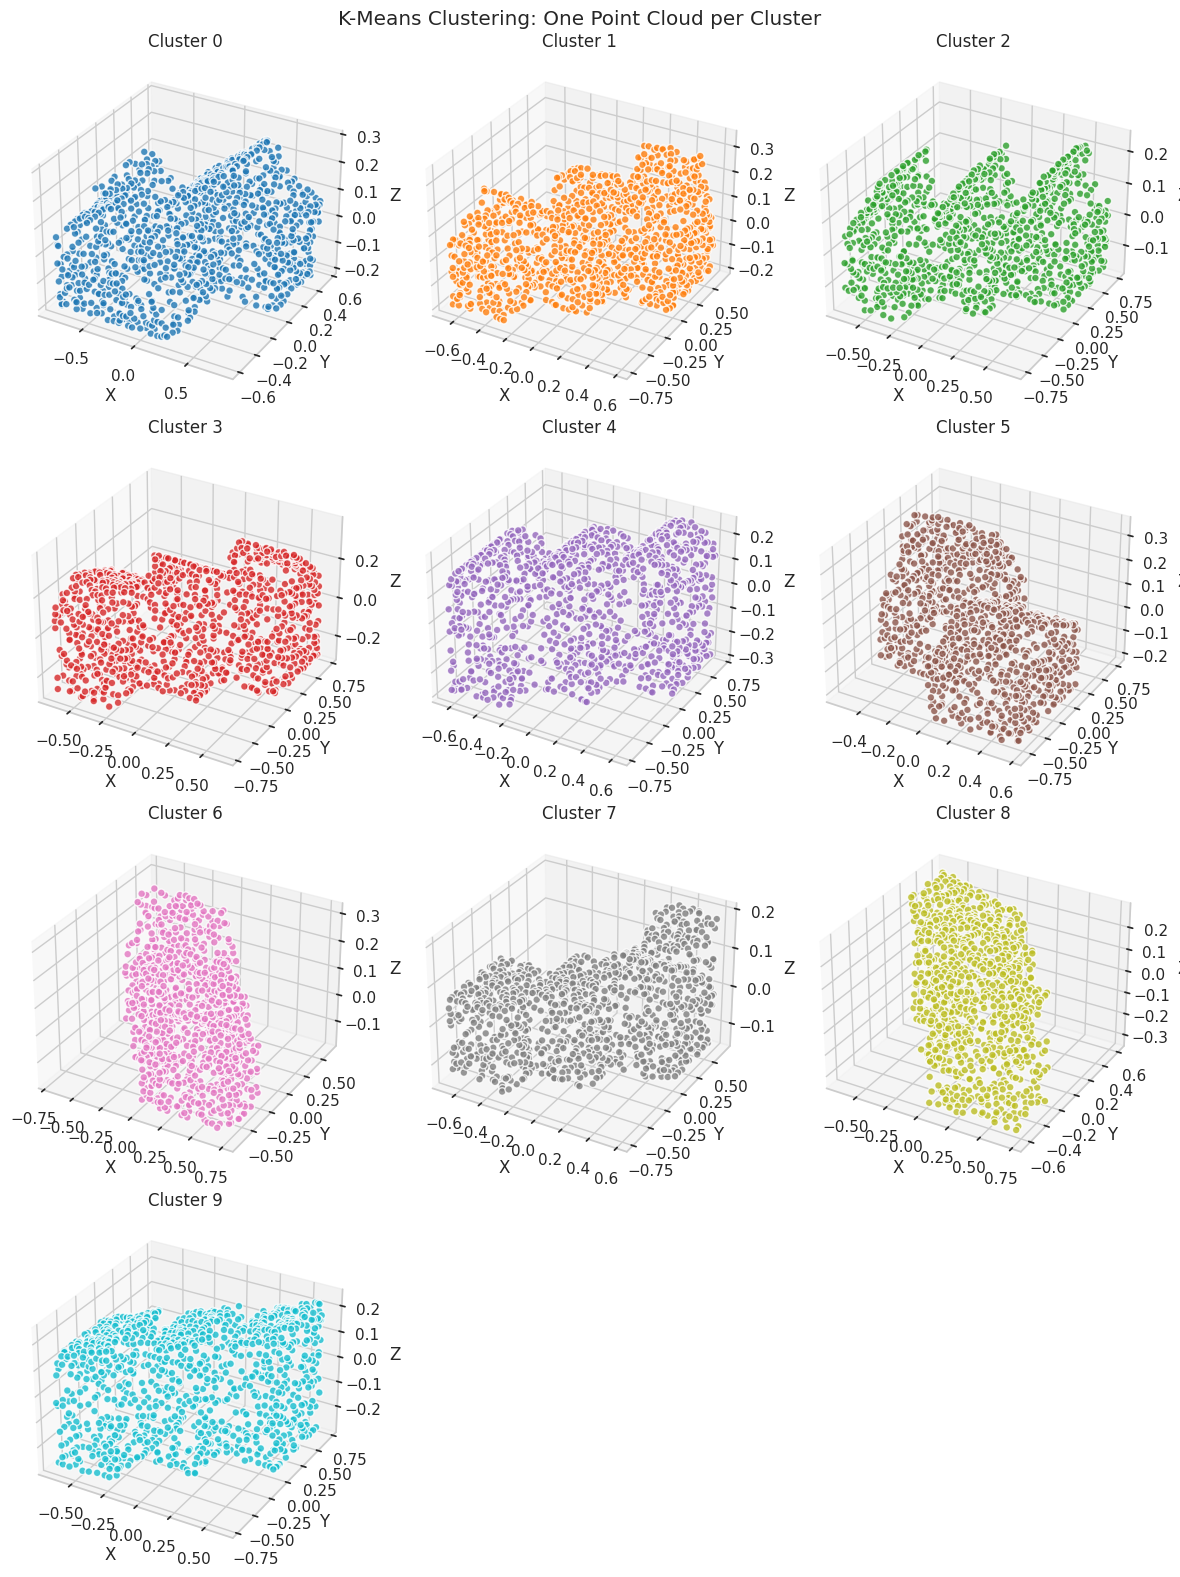

In [99]:
def visualize_point_clouds_by_cluster(point_clouds, labels, title="Point Clouds by Cluster"):
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]  # Exclude noise for visualization

    num_clusters = len(unique_labels)
    num_cols = min(num_clusters, 3)  # Set max columns to 3
    num_rows = (num_clusters + num_cols - 1) // num_cols  # Calculate rows needed

    # Use a colormap to assign colors to clusters
    cmap = plt.get_cmap("tab10")  # Choose a colormap with distinct colors (up to 10 clusters)

    fig = plt.figure(figsize=(12, 4 * num_rows))

    for i, label in enumerate(unique_labels):
        # Find the indices of point clouds corresponding to this label
        cluster_indices = np.where(labels == label)[0]

        if len(cluster_indices) > 0:
            # Select the first point cloud for this cluster
            cluster_point_cloud = point_clouds[cluster_indices[0]]  # Use the first index

            # Set a unique color for each cluster
            color = cmap(i % 10)  # Cycle through colors if more than 10 clusters

            # Create a subplot for each cluster
            ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
            ax.scatter(cluster_point_cloud[:, 0], cluster_point_cloud[:, 1], cluster_point_cloud[:, 2],
                       color=color, alpha=0.8, edgecolors='w', s=30)  # Adjust colors and style
            ax.set_title(f"Cluster {label}")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize one point cloud from each K-Means cluster
visualize_point_clouds_by_cluster(point_clouds, kmeans_labels, title="K-Means Clustering: One Point Cloud per Cluster")


##Statistical Analysis of UMAP features

In [100]:
def cluster_statistical_analysis_umap(umap_features, labels):
    # Convert UMAP features to a DataFrame for easier analysis
    df = pd.DataFrame(umap_features, columns=[f'UMAP Component {i+1}' for i in range(umap_features.shape[1])])
    df['Cluster'] = labels

    # Calculate statistics for each cluster
    summary_stats = df.groupby('Cluster').agg(['mean', 'std', 'min', 'max', 'count'])

    return summary_stats

# Perform analysis
summary_stats_umap = cluster_statistical_analysis_umap(umap_features, kmeans_labels)

# Display the statistical summary for each cluster
print("Statistical Summary for Each Cluster (K-Means):")
print(summary_stats_umap)


Statistical Summary for Each Cluster (K-Means):
        UMAP Component 1                                     UMAP Component 2  \
                    mean       std       min       max count             mean   
Cluster                                                                         
0               4.877314  0.361261  3.878841  5.533751   293         1.810052   
1               4.681742  0.293118  4.113016  5.334393   349         3.374028   
2               6.397891  0.363538  5.758698  7.418579   214         4.165004   
3               6.719419  0.393824  6.097490  7.891661   200         3.062261   
4               3.644745  0.296376  2.868139  4.201313   271         3.624964   
5               6.094558  0.384696  5.483993  7.042891   192         1.895265   
6               5.518878  0.309171  4.856708  6.116018   367         2.993520   
7               5.486049  0.287731  4.947880  6.096176   292         4.485880   
8               4.447327  0.334432  3.521398  4.965548   223 

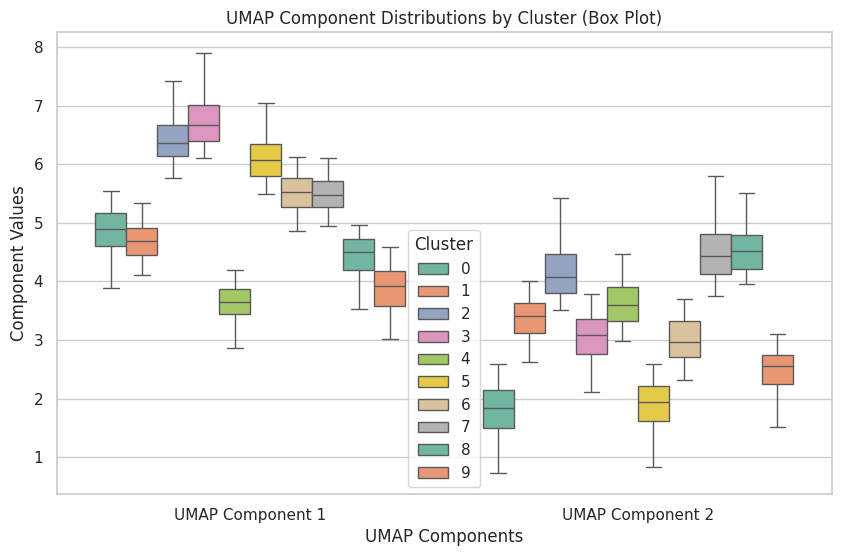

In [101]:
def plot_umap_distributions_by_cluster(umap_features, labels):
    # Create a DataFrame for easy plotting
    df = pd.DataFrame(umap_features, columns=['UMAP Component 1', 'UMAP Component 2'])
    df['Cluster'] = labels

    # Melt the DataFrame for seaborn
    df_melted = pd.melt(df, id_vars='Cluster', var_name='UMAP Component', value_name='Value')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x='UMAP Component', y='Value', hue='Cluster', palette="Set2")
    plt.title("UMAP Component Distributions by Cluster (Box Plot)")
    plt.ylabel("Component Values")
    plt.xlabel("UMAP Components")
    plt.legend(title='Cluster')
    plt.show()

# Run the function to visualize
plot_umap_distributions_by_cluster(umap_features, kmeans_labels)


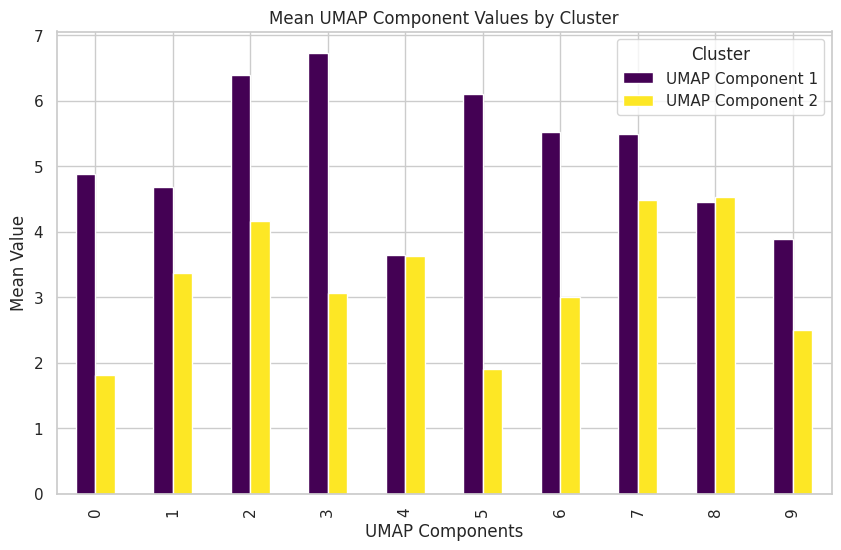

In [102]:
def plot_mean_umap_by_cluster(umap_features, labels):
    # Create a DataFrame for easy plotting
    df = pd.DataFrame(umap_features, columns=['UMAP Component 1', 'UMAP Component 2'])
    df['Cluster'] = labels

    # Calculate mean for each UMAP component by cluster
    means = df.groupby('Cluster').mean()

    # Plotting
    means.plot(kind='bar', figsize=(10, 6), colormap="viridis")
    plt.title("Mean UMAP Component Values by Cluster")
    plt.ylabel("Mean Value")
    plt.xlabel("UMAP Components")
    plt.legend(title='Cluster')
    plt.show()

# Run the function to visualize
plot_mean_umap_by_cluster(umap_features, kmeans_labels)


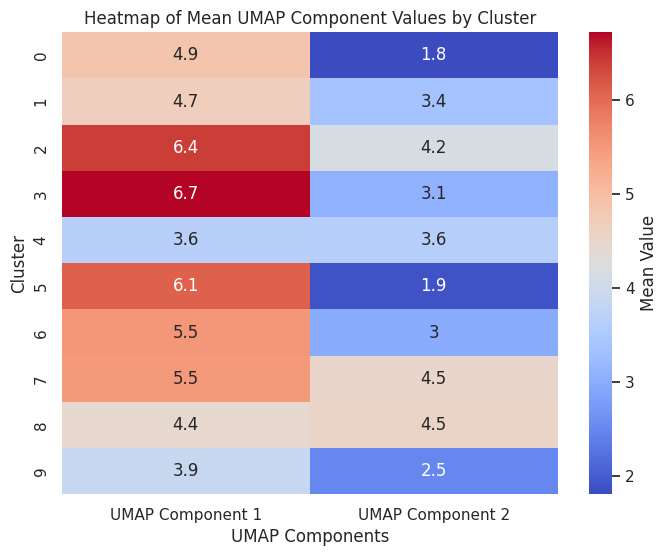

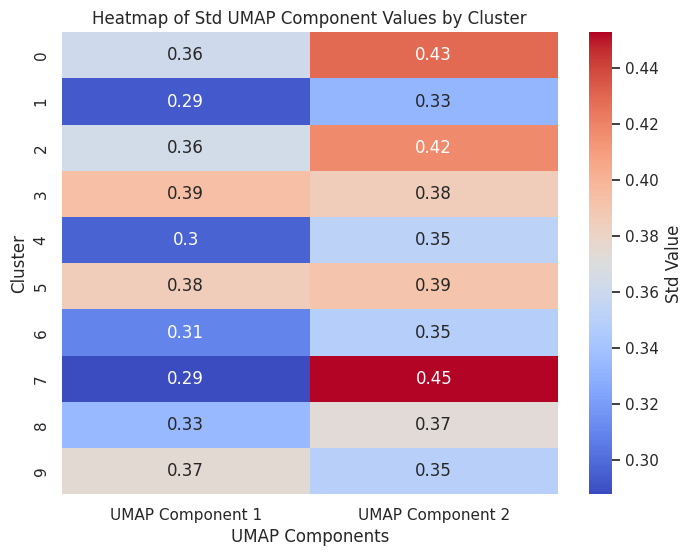

In [103]:
def plot_heatmap_umap_stats_by_cluster(umap_features, labels, stat='mean'):
    # Create a DataFrame for easy plotting
    df = pd.DataFrame(umap_features, columns=['UMAP Component 1', 'UMAP Component 2'])
    df['Cluster'] = labels

    # Calculate desired statistics for each cluster
    if stat == 'mean':
        stats = df.groupby('Cluster').mean()
    elif stat == 'std':
        stats = df.groupby('Cluster').std()
    else:
        raise ValueError("Stat must be 'mean' or 'std'")

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(stats, annot=True, cmap='coolwarm', cbar_kws={'label': f'{stat.capitalize()} Value'})
    plt.title(f"Heatmap of {stat.capitalize()} UMAP Component Values by Cluster")
    plt.xlabel("UMAP Components")
    plt.ylabel("Cluster")
    plt.show()

# Run the function to visualize mean and standard deviation
plot_heatmap_umap_stats_by_cluster(umap_features, kmeans_labels, stat='mean')
plot_heatmap_umap_stats_by_cluster(umap_features, kmeans_labels, stat='std')


#Balancing the distribution of different point clouds in the dataset
###KNN sampling

In [104]:
def knn_undersample_3d(point_clouds, labels, label_list, categorical_label_list):
    # Ensure inputs are NumPy arrays
    point_clouds = np.array(point_clouds)
    labels = np.array(labels)
    label_list = np.array(label_list)
    categorical_label_list = np.array(categorical_label_list)

    # Save the shape of each point cloud (e.g., [n_points, 3])
    original_shape = point_clouds.shape[1:]
    flattened_point_clouds = np.array([pc.flatten() for pc in point_clouds])

    # Identify unique labels and determine the minimum count for undersampling
    unique_labels, counts = np.unique(labels, return_counts=True)
    min_count = counts.min()

    balanced_point_clouds = []
    balanced_labels = []
    balanced_label_list = []
    balanced_categorical_label_list = []

    for label in unique_labels:
        # Get samples and their associated label lists for the current label
        cluster_samples = flattened_point_clouds[labels == label]
        cluster_label_list = label_list[labels == label]
        cluster_categorical_label_list = categorical_label_list[labels == label]

        # Compute centroid of the cluster
        cluster_centroid = cluster_samples.mean(axis=0)

        # Use KNN to find closest points to the centroid
        knn = NearestNeighbors(n_neighbors=min_count)
        knn.fit(cluster_samples)
        closest_indices = knn.kneighbors([cluster_centroid], return_distance=False)[0]

        # Collect the closest samples and associated label lists
        selected_samples = cluster_samples[closest_indices]
        selected_label_list = cluster_label_list[closest_indices]
        selected_categorical_label_list = cluster_categorical_label_list[closest_indices]

        # Reshape back to 3D and extend the balanced lists
        balanced_point_clouds.extend(selected_samples.reshape(-1, *original_shape))
        balanced_labels.extend([label] * min_count)
        balanced_label_list.extend(selected_label_list)
        balanced_categorical_label_list.extend(selected_categorical_label_list)

    # Convert the balanced lists to NumPy arrays for consistent output format
    return (
        np.array(balanced_point_clouds),
        np.array(balanced_labels),
        np.array(balanced_label_list),
        np.array(balanced_categorical_label_list)
    )

# Example usage:
balanced_point_clouds, balanced_labels, balanced_label_list, balanced_categorical_label_list = knn_undersample_3d(
     point_clouds, kmeans_labels, all_labels, all_cat)

# Output the results
print("Balanced point clouds shape:", balanced_point_clouds.shape)  # Expected shape: (num_samples, n_points, 3)
print("Balanced labels distribution:", np.unique(balanced_labels, return_counts=True))
print("Balanced label_list_shape:", balanced_label_list.shape)  # Should match balanced labels in size and alignment
print("Balanced categorical_label_list_shape:", balanced_categorical_label_list.shape)  # Should align with balanced samples


Balanced point clouds shape: (1920, 1024, 3)
Balanced labels distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([192, 192, 192, 192, 192, 192, 192, 192, 192, 192]))
Balanced label_list_shape: (1920, 1024)
Balanced categorical_label_list_shape: (1920, 1024, 4)


In [105]:
    point_clouds = balanced_point_clouds
    all_cat= balanced_categorical_label_list
    all_labels= balanced_label_list

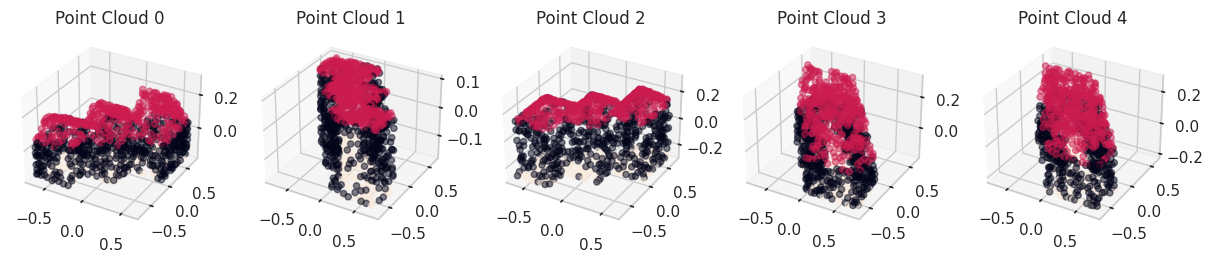

In [107]:
def check_data_quality(point_clouds, all_labels):

    num_points = point_clouds[0].shape[0]
    inconsistent_samples = []

    #Verify Point Count
    for i in range(len(point_clouds)):
        if point_clouds[i].shape[0] != num_points:
             inconsistent_samples.append(i)
             print(f"Point cloud {i} has {point_clouds[i].shape[0]} points (expected {num_points}).")

    #Check for Missing Values
    missing_labels = np.isnan(all_labels)
    if np.any(missing_labels):
        print("There are missing values in the labels.")

    #Visual Inspection of a few point clouds
    visualize_m_samples(point_clouds, all_labels)

    #Remove Inconsistent Samples
    if inconsistent_samples:
        print(f"Removing inconsistent samples: {inconsistent_samples}")
        point_clouds_cleaned = np.delete(point_clouds, inconsistent_samples, axis=0)
        all_labels_cleaned = np.delete(all_labels, inconsistent_samples, axis=0)
    else:
        point_clouds_cleaned = point_clouds
        all_labels_cleaned = all_labels

    # Return cleaned datasets
    return point_clouds_cleaned, all_labels_cleaned

def visualize_m_samples(point_clouds, all_labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1, projection='3d')
        ax.scatter(point_clouds[i][:, 0], point_clouds[i][:, 1], point_clouds[i][:, 2], c=all_labels[i], alpha=0.5)
        ax.set_title(f'Point Cloud {i}')
    plt.show()

def detect_outliers(point_clouds):

    point_clouds = np.array(point_clouds)

    # Initialize a mask for outliers
    outlier_mask = np.zeros(point_clouds.shape, dtype=bool)

    # Iterate over each point cloud
    for i in range(point_clouds.shape[0]):
        # Calculate the mean and standard deviation for each coordinate
        mean = np.mean(point_clouds[i], axis=0)  # Mean for each coordinate (x, y, z)
        std_dev = np.std(point_clouds[i], axis=0, ddof=1)  # Std deviation for each coordinate

        # Calculate Z-scores for the current point cloud
        z_scores = (point_clouds[i] - mean) / std_dev

        # Create a mask for points where any coordinate's Z-score is greater than 3
        outlier_mask[i] = np.abs(z_scores) > 3

    # Remove outliers from point clouds and corresponding labels
    cleaned_point_clouds = []
    cleaned_labels = []
    cleaned_label = [[]]

    for i in range(point_clouds.shape[0]):
        # Keep only points that are not outliers
        cleaned_point_cloud = point_clouds[i][~outlier_mask[i]]
        #print(i, ~outlier_mask[i][0][0])
        cleaned_label = all_labels[i][~outlier_mask[i][0][0]]  # Directly access labels
        cleaned_point_clouds.append(cleaned_point_cloud)
        cleaned_labels.append(cleaned_label)

    # Convert lists back to NumPy arrays
    return np.array(cleaned_point_clouds), np.array(cleaned_labels)



point_clouds_cleaned, all_labels_cleaned = check_data_quality(point_clouds=point_clouds, all_labels= all_labels)
point_clouds_cleaned, all_labels_cleaned = detect_outliers(point_clouds_cleaned)

##Class distribution



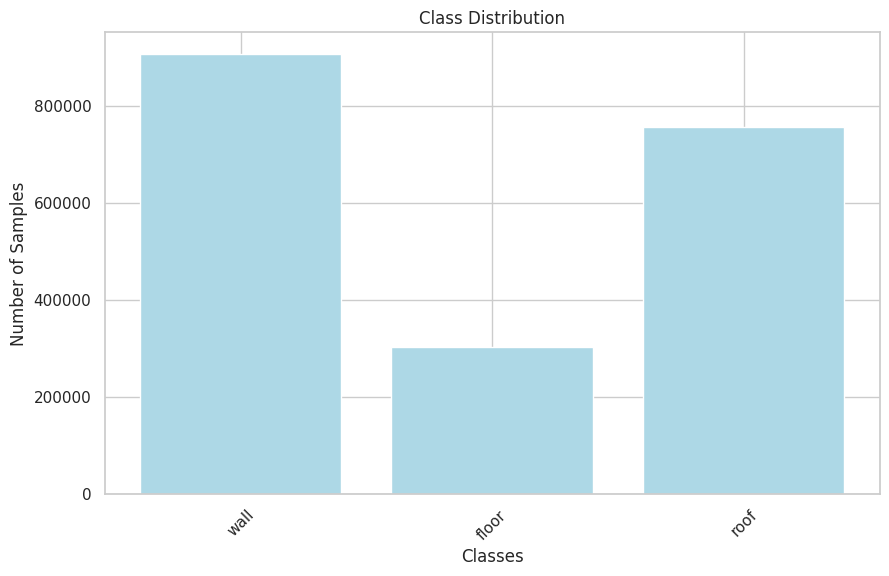

In [108]:
class_names = {0: 'other', 1: 'wall', 2: 'roof', 3: 'floor'}

# Convert point clouds and labels to numpy arrays
point_clouds = np.array(point_clouds)
all_labels = np.array(all_labels)

# Flatten labels for class distribution check
flattened_labels = all_labels.flatten()

def plot_class_distribution(labels):
    counter = Counter(labels)
    classes, counts = zip(*counter.items())

    # Map class indices to class names
    class_labels = [class_names[i] for i in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, counts, color='lightblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

# Plot original class distribution
plot_class_distribution(flattened_labels)

### Creating TensorFlow datasets

We create `tf.data.Dataset` objects for the training and validation data.
We also augment the training point clouds by applying random jitter to them.

In [109]:
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = all_cat[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = all_cat[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

Num train point clouds: 1536
Num train point cloud labels: 1536
Num val point clouds: 384
Num val point cloud labels: 384


In [110]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 4), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 4), dtype=tf.float64, name=None))>


# PointNet model training prep


##Pointnet model

In [115]:

def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


In [116]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

   # def get_config(self):
   #     config = super().get_config()
   #     config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
   #     return config

    def get_config(self):
        # Return the regularizer's configuration as a dictionary
        return {
            "num_features": self.num_features,
            "l2reg_strength": self.l2reg
        }


In [117]:

def transformation_net(inputs, num_features, name):
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])


Finally, we piece the above blocks together and implement the segmentation model.

In [118]:

def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)


## Instantiate the model

In [119]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, None, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_layer_5[0][0]    │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │          8,320 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │            512 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │        132,096 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │          4,096 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_10   │ (None, 1024)           │              0 │ input_transformation_… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │        524,800 │ global_max_pooling1d_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │          2,048 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,369,933 (28.11 MB)

 Trainable params: 7,355,981 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

## Training

For the training the authors recommend using a learning rate schedule that decays the
initial learning rate by half every 20 epochs. In this example, we use 60 epochs.

Steps per epoch: 48.
Total training steps: 2880.


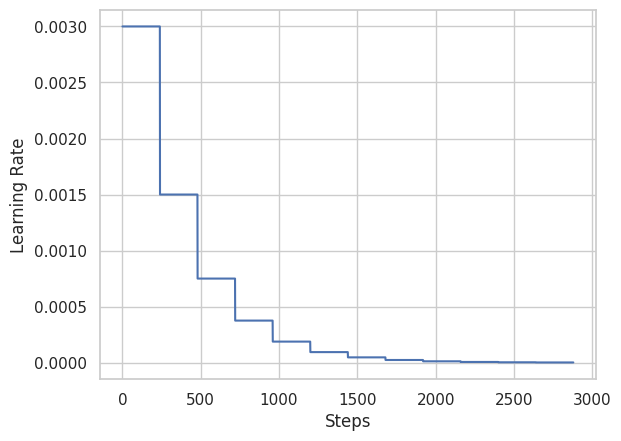

In [120]:
steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Finally, we implement a utility for running our experiments and launch model training.

In [121]:
def run_experiment(epochs):
    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # Define file paths for saving the model and weights
    checkpoint_filepath = "checkpoint.weights.h5"
    model_save_path = "/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/segmentation_model.h5"  # Path to save the full model
    weights_save_path = "/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/segmentation_model.weights.h5"  # Path to save just the weights

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)

     # Save the entire model (architecture + weights + optimizer state)
    segmentation_model.save(model_save_path)

    # Optionally, you can also save just the weights
    segmentation_model.save_weights(weights_save_path)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - accuracy: 0.5220 - loss: 15997.1465 - val_accuracy: 0.5775 - val_loss: 2155.2371
Epoch 2/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6587 - loss: 233.1714 - val_accuracy: 0.5907 - val_loss: 2615.3740
Epoch 3/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.7347 - loss: 168.8794 - val_accuracy: 0.5667 - val_loss: 1982.8973
Epoch 4/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.7663 - loss: 153.1763 - val_accuracy: 0.5558 - val_loss: 1308.6096
Epoch 5/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.7870 - loss: 145.6096 - val_accuracy: 0.5865 - val_loss: 784.4318
Epoch 6/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7979 - loss: 141.7604 - val_accuracy: 0.6167 - val_loss: 518.1548
Epoch 7/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8161 - loss: 140.7234 - val_accuracy: 0.6984 - val_loss: 334.2256
Epoch 8/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8

#Results of Training

## Visualize the training landscape

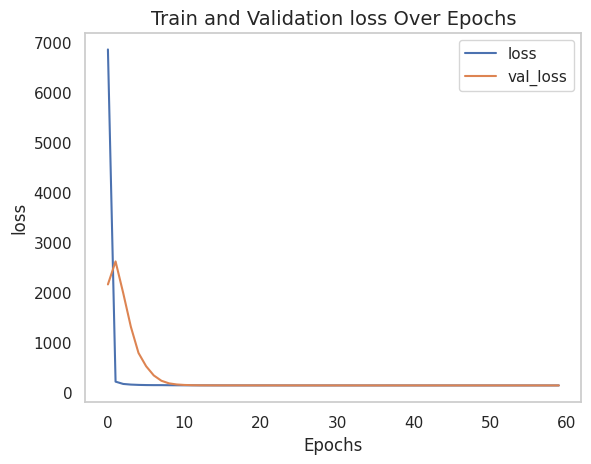

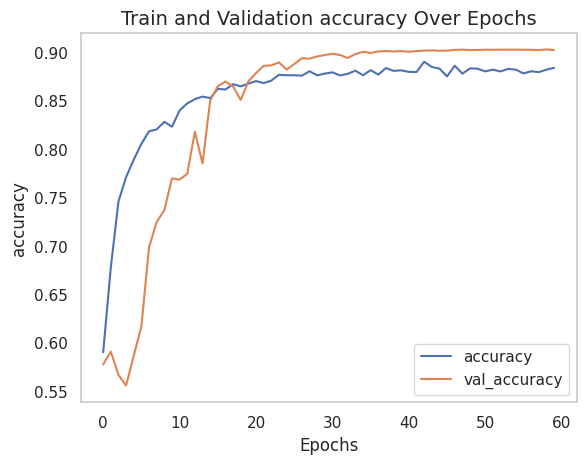

In [122]:
save_p = '/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/Plots/'


def plot_result(item, save_path=None):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

# Example usage: Plot and save loss and accuracy plots
plot_result("loss", save_path= save_p + "loss_plot.png")
plot_result("accuracy", save_path= save_p + "accuracy_plot.png")

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation prediction shape: (32, 1024, 4)
Index selected: 28
['wall', 'roof', 'floor', 'none']
[3 2 1 ... 2 2 2]


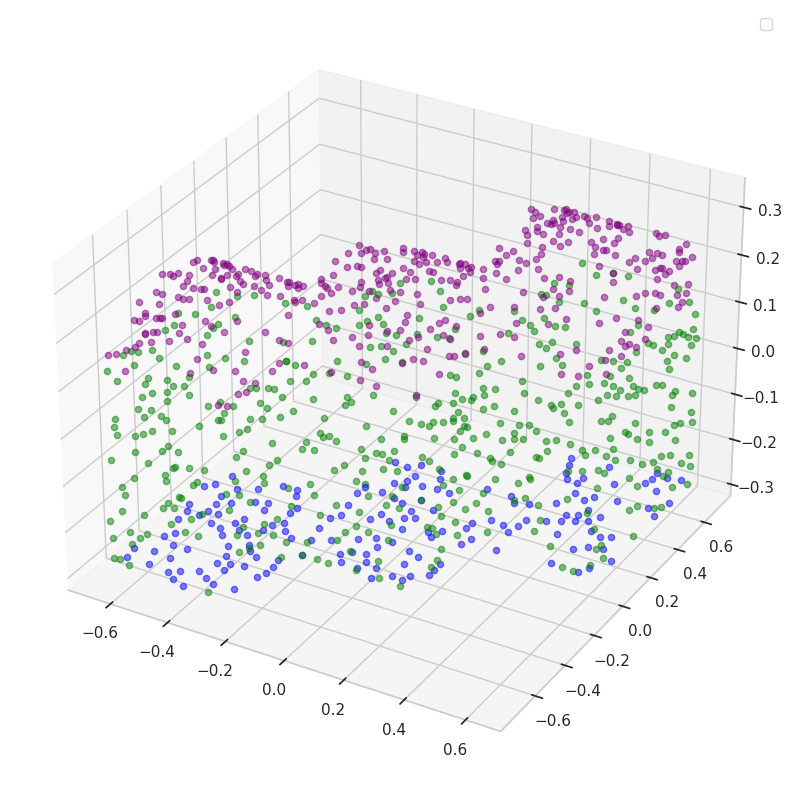

['wall', 'roof', 'floor', 'none']
[3 2 1 ... 2 2 2]


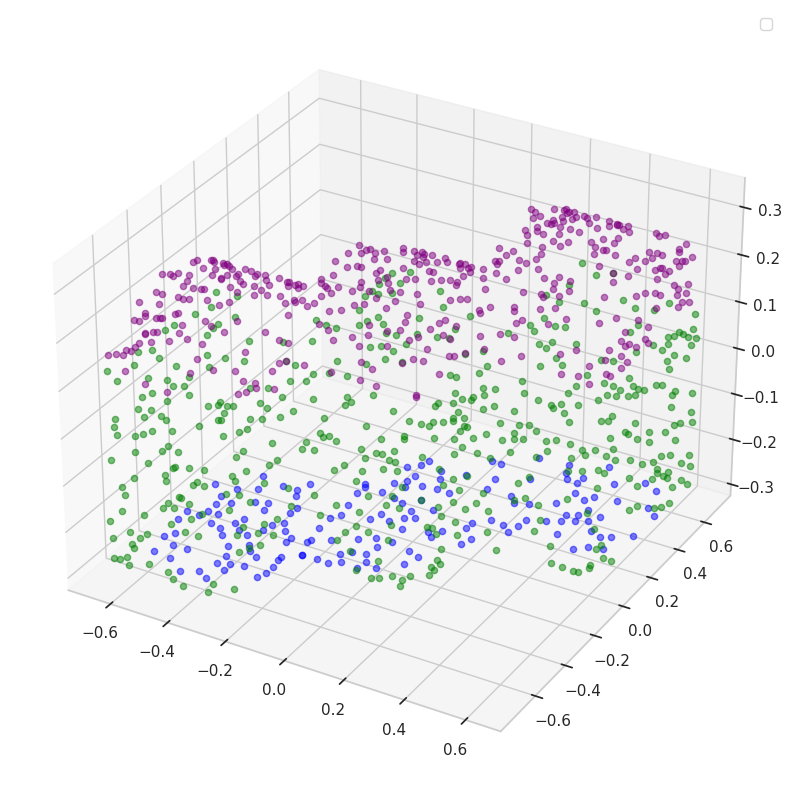

In [123]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

def visualize_data(point_cloud, labels, save_path = None):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")

    colors = ['black','green', 'purple', 'blue']

    #print (len(df))

    for i in range(len(df)):
        x, y, z = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['z']
        col = int(df.iloc[i]['label'])
        ax.scatter(x, y, z, alpha = 0.5, c=colors[col]
            )

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path)

    ax.legend()
    plt.show()

def visualize_single_point_cloud(point_clouds, label_clouds, idx, save_path=None):
    label_map = LABELS + ["none"]
    print(label_map)
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    original_labels = np.argmax(label_cloud, axis=1)
    print(original_labels)
    visualize_data(point_cloud, original_labels, save_path)


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx, save_path = save_p + 'ground_trouth.png')

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx, save_path = save_p + 'predictions.png')

Index selected: 19
['wall', 'roof', 'floor', 'none']


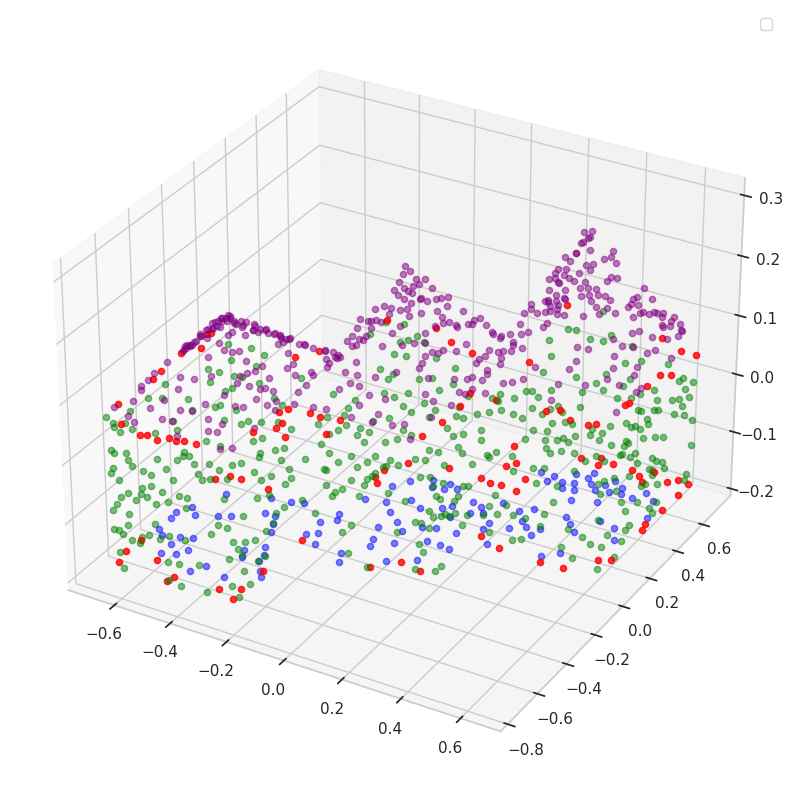

In [167]:
def visualize_misclassified_points(point_cloud, true_labels, predicted_labels, save_path=None):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "true_label": true_labels,
            "pred_label": predicted_labels,
        }
    )

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")

    # Define the colors for the true labels and red for misclassified points
    colors = ['black', 'green', 'purple', 'blue']  # Colors for true labels
    red_color = 'red'  # Color for incorrect predictions

    for i in range(len(df)):
        x, y, z = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['z']
        true_label = int(df.iloc[i]['true_label'])
        pred_label = int(df.iloc[i]['pred_label'])

        # Check if prediction is correct; if not, color the point red
        if true_label != pred_label:
            ax.scatter(x, y, z, alpha=0.8, c=red_color, label="Misclassified" if i == 0 else "")
        else:
            ax.scatter(x, y, z, alpha=0.5, c=colors[true_label])

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path)

    ax.legend()
    plt.show()


def visualize_single_point_cloud_with_misclass(point_clouds, label_clouds, predicted_labels, idx, save_path=None):
    label_map = LABELS + ["none"]
    print(label_map)

    point_cloud = point_clouds[idx]
    true_label_cloud = label_clouds[idx]
    predicted_label_cloud = predicted_labels[idx]

    # Convert one-hot encoded ground-truth labels to integer labels
    true_labels = np.argmax(true_label_cloud, axis=1)
    predicted_labels = np.argmax(predicted_label_cloud, axis=1)

    # Visualize the misclassified points
    visualize_misclassified_points(point_cloud, true_labels, predicted_labels, save_path)


# Index selection
idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with misclassified points highlighted
visualize_single_point_cloud_with_misclass(validation_batch[0], validation_batch[1], val_predictions, idx, save_path= save_p + 'missclasified_point.png')

In [170]:
# Define labels for architectural elements
class_labels = ["None", "Wall", "Roof", "Floor"]

def visualize_misclassified_points_interactive(point_cloud, true_labels, predicted_labels, save_path=None):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "true_label": true_labels,
            "pred_label": predicted_labels,
        }
    )

    # Define colors for each class (Wall, Roof, Floor) and red for misclassified points
    correct_colors = ['black', 'olivedrab', 'mediumpurple', 'mediumblue']  # Colors corresponding to Wall, Roof, Floor
    misclassified_color = 'orangered'  # Color for misclassified points

    # Separate the misclassified and correctly classified points
    misclassified_points = df[df["true_label"] != df["pred_label"]]
    correct_points = df[df["true_label"] == df["pred_label"]]

    # Debug: Check counts of each class
    #print("Counts of correctly classified points per class:")
    #for label in (np.unique(true_labels)-1):
        #class_count = len(correct_points[correct_points["true_label"] == label])
        #print(f"{class_labels[label]}: {class_count} points")

    # Create the Plotly figure
    fig = go.Figure()

    # Plot correctly classified points for each class (Wall, Roof, Floor)
    for label, color in enumerate(correct_colors):
        class_points = correct_points[correct_points["true_label"] == label]

        # Only plot if there are points for the current class
        if not class_points.empty:
            fig.add_trace(go.Scatter3d(
                x=class_points["x"],
                y=class_points["y"],
                z=class_points["z"],
                mode='markers',
                marker=dict(size=4, color=color, opacity=0.7),
                name=f'{class_labels[label]} (Correct)'
            ))

    # Plot misclassified points in red
    fig.add_trace(go.Scatter3d(
        x=misclassified_points["x"],
        y=misclassified_points["y"],
        z=misclassified_points["z"],
        mode='markers',
        marker=dict(size=5, color=misclassified_color, opacity=0.9),
        name="Misclassified"
    ))

    # Update layout to remove background axes, grid, and ticks
    fig.update_layout(
        title="3D Point Cloud with Misclassified Points Highlighted",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            bgcolor="rgba(0,0,0,0)"  # Transparent background
        ),
        showlegend=True,  # Keeps the legend
    )

    # Save the plot as an HTML file if save_path is provided
    if save_path:
        fig.write_html(save_path)

    fig.show()

def visualize_single_point_cloud_with_misclass_interactive(point_clouds, label_clouds, predicted_labels, idx, save_path=None):
    point_cloud = point_clouds[idx]
    true_label_cloud = label_clouds[idx]
    predicted_label_cloud = predicted_labels[idx]

    # Convert one-hot encoded ground-truth labels to integer labels
    true_labels = np.argmax(true_label_cloud, axis=1)
    predicted_labels = np.argmax(predicted_label_cloud, axis=1)

    # Visualize the misclassified points interactively
    visualize_misclassified_points_interactive(point_cloud, true_labels, predicted_labels, save_path)

# Randomly select an index and visualize
idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")


visualize_single_point_cloud_with_misclass_interactive(
    validation_batch[0], validation_batch[1], val_predictions, idx
)

Index selected: 9


#Implement pre-trained model

##Load the model

In [131]:
# Register the custom regularizer with the correct decorator
@tf.keras.utils.register_keras_serializable()
class OrthogonalRegularizer(Regularizer):
    def __init__(self, num_features, l2reg_strength=0.001):
        self.num_features = num_features
        self.l2reg_strength = l2reg_strength

    def __call__(self, x):
        regularization = self.l2reg_strength * tf.reduce_sum(tf.square(x))
        return regularization

    def get_config(self):
        return {"num_features": self.num_features, "l2reg_strength": self.l2reg_strength}

# Custom Tile Layer with 'repeats' as a configurable parameter
@tf.keras.utils.register_keras_serializable()
class Tile(Layer):
    def __init__(self, repeats, **kwargs):
        super(Tile, self).__init__(**kwargs)
        self.repeats = repeats

    def call(self, inputs):
        return tf.tile(inputs, multiples=self.repeats)

    def get_config(self):
        config = super(Tile, self).get_config()
        config.update({
            'repeats': self.repeats
        })
        return config

# Now load the model with both custom objects
model = load_model(
    '/content/gdrive/MyDrive/Colab_Notebooks/Pointcloud_to _BIM/segmentation_model.h5',
    custom_objects={
        'OrthogonalRegularizer': OrthogonalRegularizer,
        'Tile': Tile
    }
)

##Predict values

In [132]:
# Make predictions
predictions = model.predict(np.array( point_clouds))

# Convert class probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# predicted_labels will have shape (num_samples, num_points) with class predictions for each point
print(predicted_labels)

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
[[1 3 2 ... 1 2 1]
 [1 3 2 ... 2 3 2]
 [2 3 2 ... 2 1 1]
 ...
 [2 1 3 ... 1 2 1]
 [2 2 3 ... 1 1 1]
 [3 1 1 ... 1 2 2]]


#Calculate mIoU

Intersection over Union (IoU) is a metric used to evaluate the accuracy of object detection and segmentation tasks, particularly in scenarios where we need to compare predicted labels against ground truth labels. For each class, IoU is calculated as the ratio of the intersection of the predicted and ground truth areas to the union of these areas. Specifically, it quantifies the overlap between the predicted and actual regions corresponding to a particular class, providing a measure of how well the predicted segmentation aligns with the true segmentation. A higher IoU indicates better model performance for that class.

Mean Intersection over Union (mIoU) is the average of IoUs calculated across all classes. It serves as a comprehensive performance metric, capturing the overall ability of a model to segment various classes effectively. By averaging the IoUs, mIoU accounts for the performance on each class individually, allowing us to assess how well the model generalizes across all categories, even if some classes may be harder to predict than others. In our context, we use IoU and mIoU to evaluate the effectiveness of our point cloud segmentation model by comparing the predicted labels to the ground truth labels, helping us identify strengths and weaknesses in the model's segmentation capabilities.

In [133]:
def calculate_iou_per_class(pred_labels, gt_labels, num_classes):
    ious = []
    for c in range(num_classes):
        # Find points in the ground truth and predictions for this class
        intersection = np.sum((pred_labels == c) & (gt_labels == c))  # Intersection
        union = np.sum((pred_labels == c) | (gt_labels == c))         # Union

        if union == 0:
            iou = float('nan')  # If no points belong to this class in ground truth
        else:
            iou = intersection / union

        ious.append(iou)

    return ious

def calculate_miou(pred_labels, gt_labels, num_classes):
    """Calculate the mean IoU."""
    ious = calculate_iou_per_class(pred_labels, gt_labels, num_classes)
    # Filter out NaNs (which represent classes not present in ground truth)
    valid_ious = [iou for iou in ious if not np.isnan(iou)]

    # Compute mIoU
    miou = np.mean(valid_ious)
    return miou, ious

# Example usage with a point cloud dataset
num_classes = 4  # Adjust to the number of classes in your dataset

# Calculate mIoU
miou, ious_per_class = calculate_miou(predicted_labels, all_labels, num_classes)

print(f"mIoU: {miou}")
print(f"IoU per class: {ious_per_class}")

mIoU: 0.8015255135983539
IoU per class: [nan, 0.8041161100174635, 0.8801324390782668, 0.7203279916993314]


The calculated mean Intersection over Union (mIoU) of approximately **0.802** indicates that our point cloud segmentation model performs well overall, effectively capturing the spatial characteristics of the different classes in the dataset. This score suggests that the model achieves a good balance between precision and recall across various classes.

However, examining the IoU scores per class reveals some important insights.

The first class (rood) demonstrates an IoU of approximately **0.804**, reflecting a strong performance in segmenting this class and suggesting that the model effectively identifies and delineates its boundaries. The second class (wall), with an IoU of around **0.880**, is the best-performing class, indicating that the model excels in recognizing and segmenting this particular category, potentially due to clearer features or more substantial training data associated with it.

In contrast, the third class (floor) scores an IoU of about **0.720**, which, while still reasonable, suggests some challenges in accurately predicting this class. This lower score could indicate that the model struggles with the variability of the fourth class or that it may require more targeted training data or further tuning to improve its segmentation accuracy. Overall, while the model shows promising results, the variation in IoU scores highlights areas for potential improvement, especially for the fourth class and the need to ensure all classes are represented in both training and evaluation datasets.

##Visualize mIoU per class

<ipython-input-134-932c70ff28b5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Class', y='mIoU', data=mIoU_df, palette='viridis')


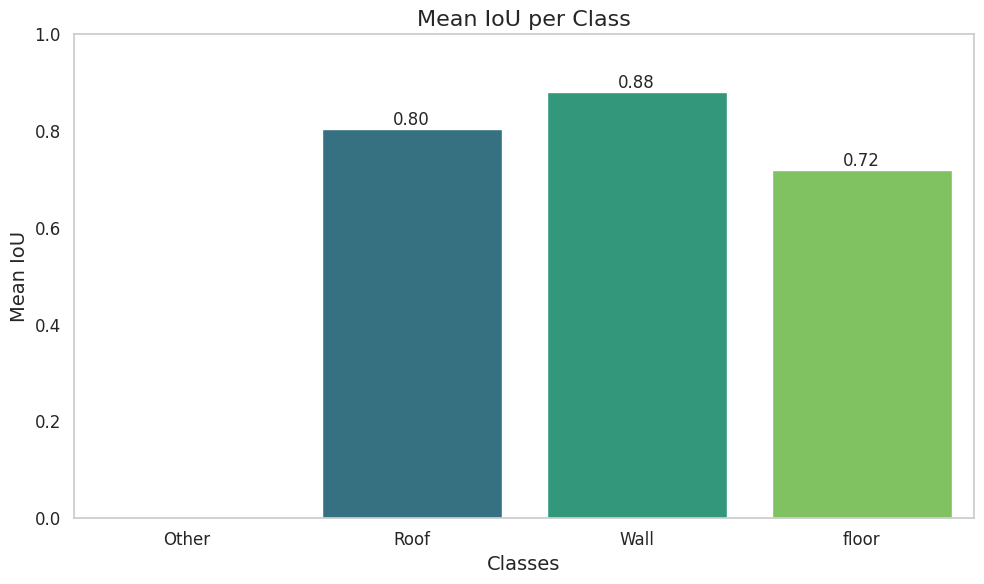

In [134]:
classes = ['Other', 'Roof', 'Wall', 'floor']
mIoU_values = ious_per_class

# Create a DataFrame for better visualization with Seaborn
mIoU_df = pd.DataFrame({'Class': classes, 'mIoU': mIoU_values})

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Class', y='mIoU', data=mIoU_df, palette='viridis')

# Add data labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Mean IoU per Class', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Mean IoU', fontsize=14)
plt.ylim(0, 1)  # Setting the y-axis limits from 0 to 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()